##Imports and Drive mount

In [6]:
# Connect to drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os
from scipy.signal import find_peaks

## Functions

In [8]:
def remove_outliers_IQR(df, col_name):
  """
  A function that clean the outliers.
  lower and upper bounds: 1.5 times the IQR from the quartiles.
  """
  before = df.shape[0]
  Q1 = df[col_name].quantile(0.25)
  Q3 = df[col_name].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 2 * IQR
  upper_bound = Q3 + 2 * IQR
  cleaned_data = df[(df[col_name] >= lower_bound) & (df[col_name] <= upper_bound)]
  after = cleaned_data.shape[0]
  n_removed = before-after
  return cleaned_data, n_removed

def remove_outliers_by_sd(df, col):
  """
  A function that clean trials outliers by the subjective effort score.
  for each force level - the SE that is 3*SD from the mean are removed
  """
  n_trials = df.shape[0]
  sub_eff = df[col]
  mean = np.mean(sub_eff)
  sd = np.std(sub_eff)
  lower_bound = mean - 2*sd
  upper_bound = mean + 2*sd
  cleaned_data = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
  n_after_remove = cleaned_data.shape[0]
  n_removed = n_trials-n_after_remove

  return cleaned_data, n_removed



In [9]:
def plot_force_trial(trial, xline=0):
  '''
  Gets a trial data and plot the force trace over time
  '''
  # extract necesery data
  target_prec = trial["Target_Force"].iloc[0]
  time_stemp = trial["fixed_time"]
  trial_mvc_force = trial["fixed_force"]
  # get peaks
  np_force = trial_mvc_force.to_numpy()
  np_time = time_stemp.to_numpy()
  peaks, _ = find_peaks(trial_mvc_force, height=0.1)

  plt.plot(time_stemp, trial_mvc_force)
  plt.plot(np_time[peaks], np_force[peaks], "x")

  plt.plot(time_stemp, [target_prec+0.05]*len(time_stemp), color="r", linestyle='--')
  plt.plot(time_stemp, [target_prec-0.05]*len(time_stemp), color="r", linestyle='--')
  plt.ylim([-0.1,1.2])
  plt.axvline(x=xline, color='orange', linestyle='--')
  plt.xlabel("Time (sec)")
  plt.ylabel("Force")
  title = "Target force: " + str(round(target_prec,3)) + " | "+ trial["Hand"].iloc[1]
  plt.title(title)
  plt.show()

In [22]:
def get_trial_cov(trial):
  '''
  Get the coefficient of variation of the force trace
  for each trial.
  '''
  # this part calculates the CoV of only the last 3 seconds:
  # last_time = trial["fixed_time"].iloc[-1]
  # range = [last_time-3,last_time]
  # time_indx = np.where(np.logical_and(trial["fixed_time"]>=last_time-3, trial["fixed_force"]<=last_time))[0]
  # last_3_sec = trial["fixed_force"][time_indx[0]:time_indx[-1]]
  # cov = np.std(last_3_sec)/np.mean(last_3_sec)

  cov = np.std(trial["fixed_force"])/np.mean(trial["fixed_force"])
  return cov

def get_peak_target(trial):
  '''
  Get the first force peak of the trial and the the difference
  between this peak and the target mvc%.
  '''
  target_prec = trial["Target_Force"].iloc[0]
  peaks, _ = find_peaks(trial["fixed_force"], height=0.1)
  if len(peaks) == 0:
    peaks = [0]
  peak_height = trial["fixed_force"].iloc[peaks[0]]
  return (peak_height-target_prec)

def get_auc_target(trial):
  '''
  Calculate the force invested in the trial and the
  target force that needed to be invested and return the
  difference between them
  '''
  # get the sum of force extracted in the trial
  y = trial["fixed_force"]
  x = trial["fixed_time"]
  auc = np.trapz(y, x)
  # get the target force to invest in the trial
  target_prec = trial["Target_Force"].iloc[0]
  target_force = target_prec*3  #3 sec

  return auc-target_force

def get_auc(trial):
  '''
  Calculate the force invested in the trial
  '''
  # get the sum of force extracted in the trial
  y = trial["fixed_force"]
  x = trial["fixed_time"]
  auc = np.trapz(y, x)

  return auc

def get_num_of_peaks(trial):
  '''
  Count how many peaks the force trace have.
  '''
  peaks, _ = find_peaks(trial["fixed_force"])
  return len(peaks)

def get_time_of_trail(trial):
  '''
  Given the trial was successful - how long was it?
  '''
  if trial['Time Within Range'].iloc[0] <3: #trial wasn't successful
    return 7
  else:
    return trial['fixed_time'].iloc[-1]

def get_sub_eff_sd(subject_data):
  sub_eff = subject_data['Subjective_Effort']
  return np.std(sub_eff)


def get_features(subject_data):
  ''' Get measures for each trial '''
  # Modify data (force, time)
  grouped = subject_data.groupby("Trial")
  # Creat empty vectors
  CoVs = []
  peaks = []
  AUC_target_ratios = []
  n_peaks = []
  AUCs = []
  # Extract
  for t in grouped.groups.keys():
    trial = grouped.get_group(t)
    CoVs.append(get_trial_cov(trial))
    peaks.append(get_peak_target(trial))
    AUC_target_ratios.append(get_auc_target(trial))
    n_peaks.append(get_num_of_peaks(trial))
    AUCs.append(get_auc(trial))
  Sum_AUC = np.cumsum(AUCs) # cumulative effort invested

  return CoVs, peaks, AUC_target_ratios, n_peaks, Sum_AUC

## Exploration and subject remove criterias

In [11]:
mvc_path = '/content/drive/Othercomputers/My Computer/results/First run/subject_C020/mvc_data.csv'
mvc_df = pd.read_csv(mvc_path)
np.max(mvc_df["Force"])*73.3

26.08270263671875

In [13]:
exp_data_path = '/content/drive/Othercomputers/My Computer/results/First_run_fixed/C020/exp_data.csv'
df = pd.read_csv(exp_data_path)


### Filter subjects

In [14]:
src_folder = '/content/drive/Othercomputers/My Computer/results/First_run_fixed'

In [15]:
for root, dirnames, filenames in os.walk(src_folder): # Go through all exp data folders
    for dir in dirnames:
      # extract info
      sub_id = dir
      exp_data_path = os.path.join(root, dir, 'exp_data.csv')
      exp_data_df = pd.read_csv(exp_data_path)
      target_force = np.array(exp_data_df['Target_Force'])
      for force in target_force:
        if force>2:
          print(sub_id)

A020
A020
A020
A023
A023
A023
C020
C020
C020
C020
C020
C020
C020
C020
C020
C020
C020
C020
C020
C020
C020
C020
C020
C020
C020


C020


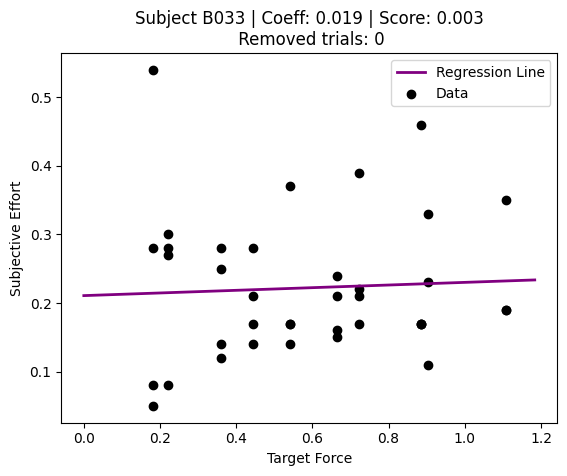

In [16]:
mvc_dic = {}
coeffs = []
subject_to_remove = []
subjects = []
removed_trials = []
for root, dirnames, filenames in os.walk(src_folder): # Go through all exp data folders
    for dir in dirnames:
      # extract info
      sub_id = dir
      exp_data_path = os.path.join(root, dir, 'exp_data.csv')
      exp_data_df = pd.read_csv(exp_data_path)

      # # remove outlier trials
      sum_removed = 0
      temp_sub_df = pd.DataFrame() #set new empty df
      grouped_sub = exp_data_df.groupby('Target_Force')
      for group in grouped_sub.groups.keys():
        temp_g = grouped_sub.get_group(group)
        # Remove outliers to the condition
        temp_g, n_removed = remove_outliers_by_sd(temp_g, "Subjective_Effort")
        # Insert the cleaned data
        temp_sub_df = pd.concat([temp_sub_df, temp_g], ignore_index = True)
        sum_removed += n_removed
      exp_data_df = temp_sub_df
      removed_trials.append(sum_removed)

      # Get MVC diff data
      sub_dom_mvc = np.max(exp_data_df[["MVC_dom_1", "MVC_dom_2", "MVC_dom_3"]].iloc[0])
      sub_non_dom_mvc = np.max(exp_data_df[["MVC_non_dom_1", "MVC_non_dom_2", "MVC_non_dom_3"]].iloc[0])
      mvc_diff = np.abs(sub_dom_mvc - sub_non_dom_mvc)
      mvc_ratio = sub_dom_mvc/sub_non_dom_mvc
      mvc_dic[sub_id] = {"dominant" : sub_dom_mvc,
                         "non-dominant": sub_non_dom_mvc,
                         "mvc_abs_diff": mvc_diff,
                         "mvc_ratio": mvc_ratio}

      # fix force for consistency
      target_force = np.array(exp_data_df['Target_Force'])
      if np.size(np.where(target_force>10))>0:
        print(sub_id)
        target_force = target_force/100

      sub_eff = np.array(exp_data_df['Subjective_Effort'])
      # corelation between force and experience
      ceff_mat = np.corrcoef(target_force, sub_eff)
      ceff = ceff_mat[0][1]
      coeffs.append(ceff)

      # fix arrays for plot
      reg = LinearRegression().fit(target_force.reshape(-1,1), sub_eff)
      x_plot = np.linspace(int(np.floor(min(target_force))), int(np.ceil(max(target_force))))
      x_plot = x_plot[(x_plot<=max(target_force)+0.1)]
      y_pred = reg.predict(x_plot.reshape(-1,1))

      # filter participants
      if ceff < 0.1:
        subject_to_remove.append(sub_id)
        # Plot outputs
        plt.plot(x_plot, y_pred, color="purple", linewidth=2, label="Regression Line")
        plt.scatter(target_force, sub_eff, color="black", label="Data")
        plt.ylabel("Subjective Effort")
        plt.xlabel("Target Force")
        title = "Subject " + sub_id + " | Coeff: " + str(round(reg.coef_[0], 3)) + " | Score: " + str(round(reg.score(target_force.reshape(-1,1), sub_eff), 3)) + "\n Removed trials: " + str(sum_removed)
        plt.title(title)
        plt.legend()
        plt.show()
        print("\n")
      elif mvc_ratio > 1.5:
        subject_to_remove.append(sub_id)
      else:
        subjects.append(sub_id)


array([[<Axes: title={'center': '0'}>]], dtype=object)

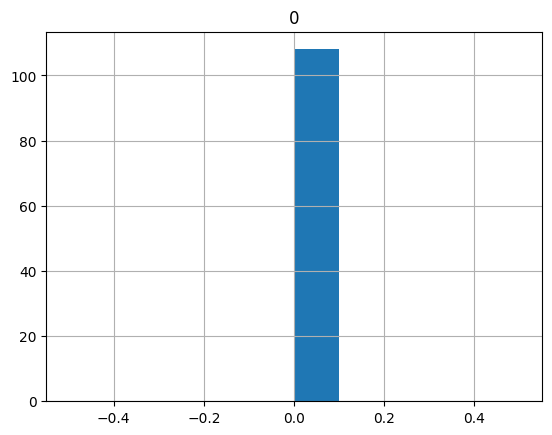

In [17]:
np.where(np.array(removed_trials)>0)
sum(removed_trials)
removed_df = pd.DataFrame(removed_trials)
removed_df.hist()

array([[<Axes: title={'center': '0'}>]], dtype=object)

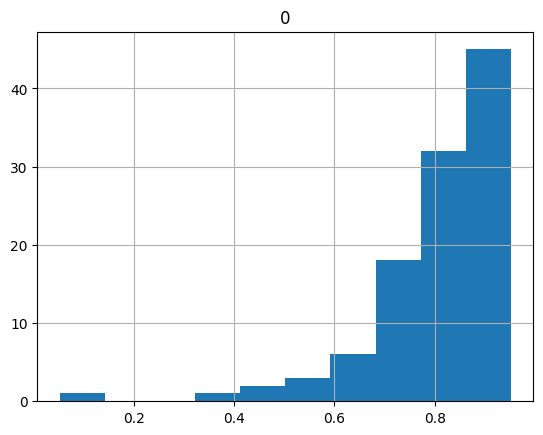

In [18]:
coeff_df = pd.DataFrame(coeffs)
coeff_df.hist()

array([[<Axes: title={'center': 'mvc_ratio'}>]], dtype=object)

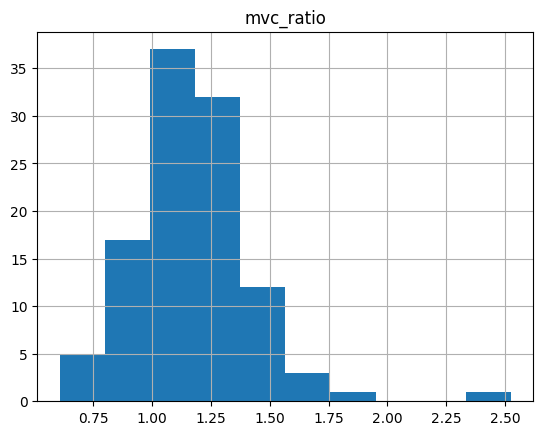

In [19]:
mvc_df = pd.DataFrame(mvc_dic).T
mvc_df.hist("mvc_ratio")

In [20]:
mvc_a = (mvc_df["mvc_ratio"]<=1.1).sum()
mvc_b = (mvc_df["mvc_ratio"]<0.9).sum()

mvc_eq = ((mvc_df["mvc_ratio"]>=0.9) & (mvc_df["mvc_ratio"]<=1.1)).sum()
print("There are ", mvc_a, " subjects with mvc_ratio<=1.1")
print("There are ", mvc_b, " subjects with mvc_ratio<0.9")
print("There are a total of ", mvc_eq, " subjects with 0.9<mvc_ratio<1.1")
print()

There are  40  subjects with mvc_ratio<=1.1
There are  9  subjects with mvc_ratio<0.9
There are a total of  31  subjects with 0.9<mvc_ratio<1.1



## Create features data frame for each subject

In [48]:
cols = ['Participant', 'Trial', 'Target_Force', 'Subjective_Effort', 'Hand',
       'Success', 'AUC-target', 'Peak-target', 'CoV', 'Sum_AUC', 'Apathy', 'PHQ9', 'GAD7',
       'Group', 'n_Peaks', 'Target_Force_t-1', 'Subjective_Effort_t-1','mvc_ratio']
features_data = pd.DataFrame(columns=cols)

In [49]:
for root, dirnames, filenames in os.walk(src_folder): # Go through all exp data folders
    for dir in dirnames:
      if dir in subjects: # use only subjects that had a regression coef >=0.2 and mvc_ratio<1.5
        # extract info
        sub_id = dir
        exp_trials_path = os.path.join(root, dir, 'exp_trials.csv')
        exp_trials_df = pd.read_csv(exp_trials_path)
        exp_data_path = os.path.join(root, dir, 'exp_data.csv')
        exp_data_df = pd.read_csv(exp_data_path)

        # get mvc ratio
        sub_dom_mvc = np.max(exp_data_df[["MVC_dom_1", "MVC_dom_2", "MVC_dom_3"]].iloc[0])
        sub_non_dom_mvc = np.max(exp_data_df[["MVC_non_dom_1", "MVC_non_dom_2", "MVC_non_dom_3"]].iloc[0])
        mvc_ratio = sub_dom_mvc/sub_non_dom_mvc

        # Create features DF
        exp_data_df.drop(['MVC_dom_1', 'MVC_dom_2',	'MVC_dom_3', 'MVC_non_dom_1',
                          'MVC_non_dom_2', 'MVC_non_dom_3',"Peak/target",
                          "AUC/target", ], axis=1, inplace=True)
        features_df = exp_data_df
        # Extract features
        CoVs, peaks, AUC_target_ratios, n_peaks, sum_auc = get_features(exp_trials_df)

        # Update DF
        features_df['CoV'] = CoVs
        features_df['AUC-target'] =AUC_target_ratios
        features_df['Sum_AUC'] = sum_auc
        features_df['Peak-target'] = peaks
        features_df["n_Peaks"] = n_peaks
        features_df["Target_Force_t-1"] = np.insert(features_df['Target_Force'][0:-1], 0, None)
        features_df["Subjective_Effort_t-1"] = np.insert(features_df['Subjective_Effort'][0:-1], 0, None)
        features_df["mvc_ratio"] = mvc_ratio

        # Save features DF
        sub_path = os.path.join(root ,dir, 'features.csv')
        features_df.to_csv(sub_path, index=False)

        # Insert participant to main df
        features_data = pd.concat([features_data, features_df])

# Fix AES scores
features_data.insert(11, "AES", features_data["Apathy"].apply(lambda x : 72-x+18))
features_data.drop("Apathy", axis=1, inplace=True)

# Save all participants features DF
features_data.to_csv("/content/drive/MyDrive/Colab Notebooks/Effort_function/Data/features_data_mvc_ratio_20.01.25.csv", index=False)

<ipython-input-49-bce37f354c20>:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  features_data = pd.concat([features_data, features_df])


In [58]:
features_data.to_csv("/content/drive/MyDrive/Colab Notebooks/Effort_function/Data/features_data_mvc_ratio_20.01.25.csv", index=False)

In [60]:
pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Effort_function/Data/features_data_mvc_ratio_20.01.25.csv")

,Participant,Trial,Target_Force,Subjective_Effort,Hand,Success,AUC-target,Peak-target,CoV,Sum_AUC,AES,PHQ9,GAD7,Group,n_Peaks,Target_Force_t-1,Subjective_Effort_t-1,mvc_ratio
0,B003,0,0.231527,0.20,Non_Dominant,No,0.615672,-0.035604,0.397154,1.310252,45.0,12.0,18.0,0,50,NaN,NaN,1.174127
1,B003,1,0.345533,0.35,Dominant,No,0.821686,-0.092096,0.390386,3.168536,45.0,12.0,18.0,0,46,0.231527,0.20,1.174127
2,B003,2,0.463053,0.40,Non_Dominant,No,1.155067,-0.031924,0.421358,5.712763,45.0,12.0,18.0,0,39,0.345533,0.35,1.174127
3,B003,3,0.518299,0.40,Dominant,Yes,1.079452,-0.084880,0.483950,8.347112,45.0,12.0,18.0,0,38,0.463053,0.40,1.174127
4,B003,4,0.231527,0.15,Non_Dominant,Yes,0.607557,0.024565,0.318488,9.649249,45.0,12.0,18.0,0,40,0.518299,0.40,1.174127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3719,C029,33,0.422203,0.42,Non_Dominant,No,1.362181,-0.073547,0.358788,108.229327,39.0,12.0,10.0,1,32,0.568447,0.61,0.937500
3720,C029,34,0.378965,0.24,Dominant,Yes,0.704803,0.005588,0.130311,110.071024,39.0,12.0,10.0,1,25,0.422203,0.42,0.937500
3721,C029,35,0.211101,0.21,Non_Dominant,Yes,0.560352,0.307546,0.372087,111.264680,39.0,12.0,10.0,1,37,0.378965,0.24,0.937500
3722,C029,36,0.568447,0.46,Dominant,Yes,1.446759,-0.206902,0.236838,114.416780,39.0,12.0,10.0,1,20,0.211101,0.21,0.937500


! the below part is not updated to: peak-target feature !

##one subject


In [63]:
# extract files
sub_id = "A002"
exp_data_path = '/content/drive/Othercomputers/My Computer/results/First_run_fixed/A002/exp_data.csv'
exp_trials_path = '/content/drive/Othercomputers/My Computer/results/First_run_fixed/A002/exp_trials.csv'

exp_data_df = pd.read_csv(exp_data_path)
exp_trials_df = pd.read_csv(exp_trials_path)

# Create features DF
exp_data_df.drop(['MVC_dom_1', 'MVC_dom_2',	'MVC_dom_3', 'MVC_non_dom_1', 'MVC_non_dom_2', 'MVC_non_dom_3'], axis=1, inplace=True)
features_df = exp_data_df

# Extract features
CoVs, peaks, AUC_target_ratios, n_peaks, Sum_AUC = get_features(exp_trials_df)
sub_eff_sd = get_sub_eff_sd(exp_data_df)

# Update DF
features_df['CoV'] = CoVs
features_df['AUC-target'] =AUC_target_ratios
features_df['Peak-target'] = peaks
features_df["n_Peaks"] = n_peaks
features_df["Sum_AUC"] = Sum_AUC
features_df["Subjective_effort_SD"] = sub_eff_sd
features_df["Target_Force_t-1"] = np.insert(features_df['Target_Force'][0:-1], 0, None)
features_df["Subjective_Effort_t-1"] = np.insert(features_df['Subjective_Effort'][0:-1], 0, None)

In [64]:
features_df

,Participant,Trial,Target_Force,Subjective_Effort,Hand,Success,AUC/target,Peak/target,CoV,Apathy,PHQ9,GAD7,Group,AUC-target,Peak-target,n_Peaks,Sum_AUC,Subjective_effort_SD,Target_Force_t-1,Subjective_Effort_t-1
0,A002,0,0.458371,0.38,Dominant,No,1.883003,0.768345,0.320633,58,12,7,0,1.214229,-0.106184,47,2.589343,0.299162,NaN,NaN
1,A002,1,0.785390,0.78,Non_Dominant,Yes,1.351568,0.950226,0.365122,58,12,7,0,0.828353,-0.039092,38,5.773866,0.299162,0.458371,0.38
2,A002,2,0.305581,0.12,Dominant,Yes,1.594343,1.088351,0.242310,58,12,7,0,0.544859,0.026998,38,7.235467,0.299162,0.785390,0.78
3,A002,3,1.047187,1.00,Non_Dominant,No,1.411152,0.747549,0.405398,58,12,7,0,1.291658,-0.264363,44,11.668684,0.299162,0.305581,0.12
4,A002,4,0.458371,0.37,Dominant,Yes,1.538406,0.717341,0.374175,58,12,7,0,0.740369,-0.129563,40,13.784166,0.299162,1.047187,1.00
5,A002,5,0.261797,0.40,Non_Dominant,Yes,2.057715,2.503771,0.382508,58,12,7,0,0.830719,0.393682,49,15.400274,0.299162,0.458371,0.37
6,A002,6,0.611161,0.43,Dominant,Yes,1.374832,1.119200,0.433877,58,12,7,0,0.687249,0.072851,29,17.921007,0.299162,0.261797,0.40
7,A002,7,0.785390,0.83,Non_Dominant,Yes,1.243586,0.848416,0.352811,58,12,7,0,0.573930,-0.119052,33,20.851107,0.299162,0.611161,0.43
8,A002,8,0.763952,0.82,Dominant,Yes,1.275179,1.024679,0.434346,58,12,7,0,0.630670,0.018854,29,23.773632,0.299162,0.785390,0.83
9,A002,9,1.308983,1.00,Non_Dominant,No,1.042904,0.549020,0.292366,58,12,7,0,0.168484,-0.590326,47,27.869065,0.299162,0.763952,0.82


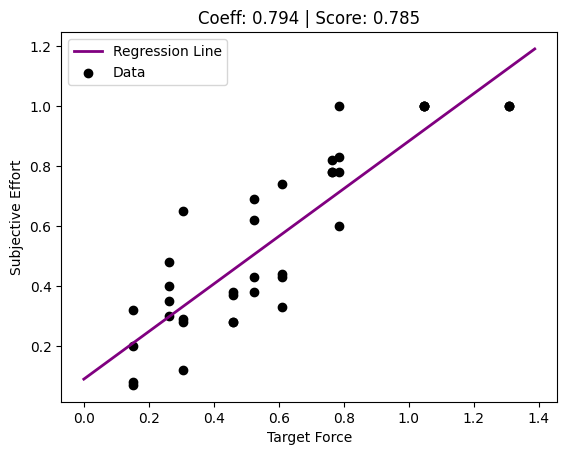

In [65]:
target_force = np.array(exp_data_df['Target_Force'])
sub_eff = np.array(exp_data_df['Subjective_Effort'])

reg = LinearRegression().fit(target_force.reshape(-1,1), sub_eff)

x_plot = np.linspace(int(np.floor(min(target_force))), int(np.ceil(max(target_force))))
x_plot = x_plot[(x_plot<=max(target_force)+0.1)]
y_pred = reg.predict(x_plot.reshape(-1,1))

# Plot outputs
plt.plot(x_plot, y_pred, color="purple", linewidth=2, label="Regression Line")
plt.scatter(target_force, sub_eff, color="black", label="Data")
plt.ylabel("Subjective Effort")
plt.xlabel("Target Force")
title = "Coeff: " + str(round(reg.coef_[0], 3)) + " | Score: " + str(round(reg.score(target_force.reshape(-1,1), sub_eff), 3))
plt.title(title)
plt.legend()
plt.show()

1.4617475289157893e-06


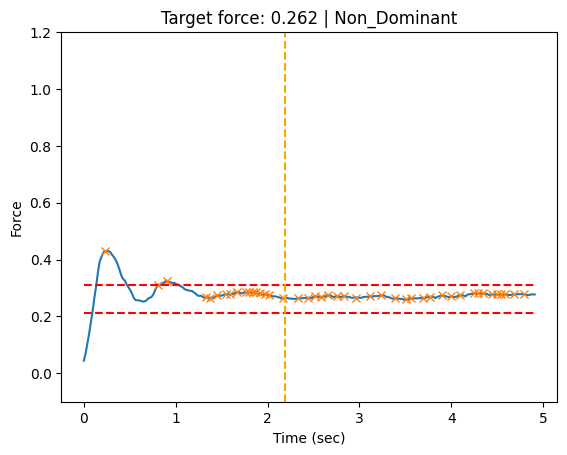

44


,Trial,TimeStemp,fixed_time,Force,fixed_force,Reaction Time,Subjective Effort,Target_Force,Hand,Time Within Range
4458,15,754308.274508,0.000000,0.013733,0.044423,0.387693,0.3,0.261797,Non_Dominant,3.016644
4459,15,754327.887535,0.019613,0.021667,0.070089,0.387693,0.3,0.261797,Non_Dominant,3.016644
4460,15,754347.520828,0.039246,0.032654,0.105627,0.387693,0.3,0.261797,Non_Dominant,3.016644
4461,15,754366.434813,0.058160,0.043335,0.140178,0.387693,0.3,0.261797,Non_Dominant,3.016644
4462,15,754387.272120,0.078998,0.056458,0.182626,0.387693,0.3,0.261797,Non_Dominant,3.016644
...,...,...,...,...,...,...,...,...,...,...
4708,15,759139.338732,4.831064,0.085144,0.275420,0.387693,0.3,0.261797,Non_Dominant,3.016644
4709,15,759158.363819,4.850089,0.085144,0.275420,0.387693,0.3,0.261797,Non_Dominant,3.016644
4710,15,759176.267147,4.867993,0.085754,0.277394,0.387693,0.3,0.261797,Non_Dominant,3.016644
4711,15,759196.100235,4.887826,0.085754,0.277394,0.387693,0.3,0.261797,Non_Dominant,3.016644


In [67]:
grouped_by_trial = exp_trials_df.groupby("Trial")
trial = grouped_by_trial.get_group(15)

# covs, peaks, auc = get_measures(exp_trials_df)


force_trace = trial["fixed_force"]
trial_times = trial["fixed_time"]

win_size = int(np.floor(len(force_trace)/20))
variances = np.zeros(len(force_trace) - win_size + 1)
for i in range(len(variances)):
  window = force_trace[i:i+win_size]
  variances[i] = np.var(window)

steady_index = np.argmin(variances)
print(min(variances))
plot_force_trial(trial, xline=trial_times.iloc[steady_index])


peaks, _ = find_peaks(trial["fixed_force"], 0.1)
print(len(peaks))
get_trial_cov(trial)

trial

In [ ]:
CoVs, peaks, AUC_target_ratios, n_peaks, trial_time = get_features(exp_trials_df)
sub_eff_sd = get_sub_eff_sd(exp_data_df)

exp_data_df['CoV'] = CoVs
exp_data_df['AUC/target'] =AUC_target_ratios
exp_data_df['Peak/target'] = peaks
exp_data_df["n_Peaks"] = n_peaks
exp_data_df["Trial_time"] = trial_time
exp_data_df["Subjective_effort_SD"] = sub_eff_sd
exp_data_df.drop(['MVC_dom_1', 'MVC_dom_2',	'MVC_dom_3', 'MVC_non_dom_1', 'MVC_non_dom_2', 'MVC_non_dom_3'], axis=1, inplace=True)

In [ ]:
exp_data_df

,Participant,Trial,Target_Force,Subjective_Effort,Hand,Success,AUC/target,Peak/target,CoV,Apathy,PHQ9,GAD7,Group,n_Peaks,Trial_time,Subjective_effort_SD
0,A008,0,0.621359,0.50,Non_Dominant,No,2.158583,0.304687,0.579120,57,13,8,0,59,NaN,0.248193
1,A008,1,0.515000,0.30,Dominant,Yes,1.622011,1.383495,0.580319,57,13,8,0,39,4.938536,0.248193
2,A008,2,1.242718,0.60,Non_Dominant,No,1.762887,0.929688,0.578744,57,13,8,0,39,NaN,0.248193
3,A008,3,0.128750,0.15,Dominant,No,2.486361,4.599515,0.580610,57,13,8,0,66,NaN,0.248193
4,A008,4,0.310680,0.25,Non_Dominant,No,2.374654,1.601563,0.579540,57,13,8,0,55,NaN,0.248193
5,A008,5,0.128750,0.10,Dominant,Yes,2.141913,1.808252,0.581336,57,13,8,0,69,6.432744,0.248193
6,A008,6,0.621359,0.50,Non_Dominant,Yes,1.541372,0.792969,0.579953,57,13,8,0,33,5.121647,0.248193
7,A008,7,0.257500,0.30,Dominant,Yes,1.571312,1.067961,0.577415,57,13,8,0,40,4.760388,0.248193
8,A008,8,1.553398,0.80,Non_Dominant,No,0.956507,0.562500,0.578914,57,13,8,0,38,NaN,0.248193
9,A008,9,0.643750,0.45,Dominant,Yes,1.563690,1.242718,0.580199,57,13,8,0,26,4.869039,0.248193


# subjective effort scoring

In [ ]:
sub_eff = exp_data_df['Subjective_Effort']
min_sub_eff = min(sub_eff)
max_sub_eff = max(sub_eff)
mean_sub_eff = np.mean(sub_eff)
sd_sub_eff = np.std(sub_eff)
unique_vals = len(np.unique(exp_data_df['Subjective_Effort']))

print("Subjective effort range: ", min_sub_eff, ":", max_sub_eff)
print("Range abs: ", max_sub_eff-min_sub_eff)
print("Subjective effort mean: ", mean_sub_eff, "(SD:", sd_sub_eff, ")" )
print("There are ", unique_vals, " unique values.")

Subjective effort range:  0.07 : 1.0
Range abs:  0.9299999999999999
Subjective effort mean:  0.5657894736842105 (SD: 0.299162265237159 )
There are  25  unique values.


(array([6., 8., 5., 1., 4., 5., 2., 2., 2., 3.]),
 array([0.05 , 0.135, 0.22 , 0.305, 0.39 , 0.475, 0.56 , 0.645, 0.73 ,
        0.815, 0.9  ]),
 <BarContainer object of 10 artists>)

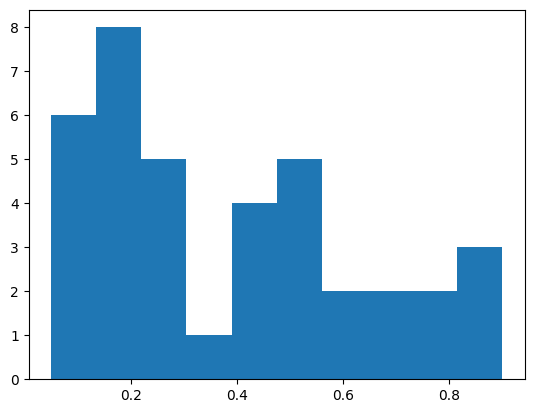

In [ ]:
plt.hist(exp_data_df['Subjective_Effort'])